In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import sys

import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import utils as tl_utils
from transformer_lens import HookedTransformer
from collections import defaultdict
from tqdm.auto import tqdm
import einops

/data/phillip_guo/miniconda3/envs/cb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup Model

In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct" 
# model_name_or_path = "/data/phillip_guo/circuit-breakers/harmfulness_probe/llama_lora_trained_full_kl"
model_type = "llama3_8b" # 
# model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.2"
# model_type = "mistral_7b"
probe_type = "linear"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16,          
            low_cpu_mem_usage=True,
            # attn_implementation="flash_attention_2",
            device_map="cuda",
            trust_remote_code=True,)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
train_mt = True

class Config:
    def __init__(self, n_layers, n_heads, d_model):
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.d_model = d_model

model.cfg = Config(n_layers=32, n_heads=32, d_model=4096)

# if model_name_or_path == "mistralai/Mistral-7B-Instruct-v0.1":
#     real_model_name = "mistralai/Mistral-7B-Instruct-v0.2"
#     real_model = AutoModelForCausalLM.from_pretrained(real_model_name, torch_dtype=torch.bfloat16)
save_dir = f"lora_trained_{model_type}_{probe_type}_train_mt_{train_mt}_lat"
os.makedirs(save_dir, exist_ok=True)

cache_layers = [10, 20, 31]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


In [3]:
# for lora setup
from peft import LoraConfig, get_peft_model
target_modules = [
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
]
lora_dropout = 0.05
lora_r = 16
lora_alpha = 16
bias = "none"
task_type = "CAUSAL_LM"
layers_to_transform = [i for i in range(max(cache_layers)+1)]

lora_args = {
    "r": lora_r,
    "lora_alpha": lora_alpha,
    "target_modules": target_modules,
    "lora_dropout": lora_dropout,
    "bias": bias,
    "layers_to_transform": layers_to_transform,
    "task_type": task_type,
}
lora_config = LoraConfig(
    **lora_args
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


In [4]:

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)

        # for 1 layer:
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

        # # for 2 layers
        # self.fc2 = torch.nn.Linear(hidden_size, hidden_size // 2)
        # self.fc3 = torch.nn.Linear(hidden_size // 2, output_size)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))

        # for 1 layer
        return self.fc2(x)

        # # for 2 layers
        # x = self.relu(self.fc2(x))
        # return self.fc3(x)

class Linear(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)


class Scale(torch.nn.Module):
    def __init__(self, m, scale: float = 100):
        super().__init__()
        self.m = m
        self.scale = torch.nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        return self.m(x) * self.scale

def zero_init(m):
    # if isinstance(m, torch.nn.Linear):
    #     m.weight.data.zero_()
    #     if m.bias is not None:
    #         m.bias.data.zero_()
    for name, p in m.named_parameters():
        p.data.zero_()
    return m

In [5]:
hidden_size = 32
probe_dict = {}
for layer_i in cache_layers:
    # probe_dict[layer_i] = Scale(zero_init(MLP(model.cfg.d_model, hidden_size, 1))).cuda()
    if probe_type == "mlp":
        print("Using MLP probe")
        probe_dict[layer_i] = Scale(MLP(model.cfg.d_model, hidden_size, 1)).cuda()
    elif probe_type == "linear":
        print("Using Linear probe")
        probe_dict[layer_i] = Scale(Linear(model.cfg.d_model, 1)).cuda()
    else:
        raise ValueError(f"Probe type {probe_type} not recognized")

Using Linear probe
Using Linear probe
Using Linear probe


## Setup Datasets

In [6]:
# strip llama3 chat template
# 'prompt' column looks like: <|begin_of_text|><|start_header_id|>user<|end_header_id|> Can you tell me about some of the notable start-ups operating in Sao Paulo's tech scene?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

# include_system_prompt = False

def strip_template(text, handle_begin_assistant=False):
    stripped_text = text.split("<|eot_id|>")[0].split("<|end_header_id|>")[1].strip()
    # if there is any punctuation at the end (., !, ?), remove it
    if stripped_text[-1] in ['.', '!']:
        stripped_text = stripped_text[:-1]
    if handle_begin_assistant:
        # there is some contant after "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
        assistant_text = text.split("<|eot_id|><|start_header_id|>assistant<|end_header_id|>")[1] 
        # strip whitespace
        assistant_text = assistant_text.strip()
        return stripped_text, assistant_text
    else:
        return stripped_text

def apply_chat_template(prompt_list):
    new_prompt_list = []
    for prompt in prompt_list:
        prompt = tokenizer.apply_chat_template([{"role": "system", "content": "You are a helpful AI Assistant!"}, {"role": "user", "content": prompt}], tokenize=False) + "\n\n"
        new_prompt_list.append(prompt)
    return new_prompt_list

def add_output_and_get_output_pos(prompt_list=None, output_list=None, tokenizer=tokenizer, dataset=None, first_n=None, assert_end_newline=False, add_space_between_output_and_input=False, remove_bos_token=True):
    # if dataset is not None:
    #     if first_n is None:
    #         first_n = len(dataset["prompt"])
    #     tokenized_prompts = tokenizer(dataset["prompt"][:first_n]).input_ids
    #     if add_space_between_output_and_input:
    #         full_messages = [x + "\n\n" + y for x, y in zip(dataset["prompt"][:first_n], dataset["completion"][:first_n])]
    #     else:
    #         full_messages = [x + y for x, y in zip(dataset["prompt"][:first_n], dataset["completion"][:first_n])]
    # else:
    if dataset is not None:
        prompt_list = dataset["prompt"]
        output_list = dataset["completion"]
    if add_space_between_output_and_input:
        prompt_list = [x + " " for x in prompt_list]
    if first_n is None:
        first_n = len(prompt_list)
    if remove_bos_token:
        for i in range(len(prompt_list)):
            if tokenizer.bos_token in prompt_list[i]:
                prompt_list[i] = prompt_list[i].replace(tokenizer.bos_token, "")
                # also remove the leading whitespace if it exists
                if prompt_list[i][0] == " ":
                    prompt_list[i] = prompt_list[i][1:]
    tokenized_prompts = tokenizer(prompt_list[:first_n])
    full_messages = [x + y for x, y in zip(prompt_list[:first_n], output_list[:first_n])]
    tokenized_full_messages = tokenizer(full_messages).input_ids

    end_input_positions = [len(tokenized_prompts[i]) - len(tokenized_full_messages[i]) - 1 for i in range(len(full_messages))]
    
    if assert_end_newline:
        tokenized_full_messages = tokenizer(full_messages, padding=True, return_tensors="pt").input_ids
        assert (tokenized_full_messages[range(len(end_input_positions)), end_input_positions] == tokenizer("\n\n").input_ids[-1]).all(), f"Last token is not eos_token_id"
    return full_messages, end_input_positions


# harmbench_behaviors = pd.read_csv("tasks/harmbench/data/harmbench_data/behavior_datasets/harmbench_behaviors_text_all.csv").set_index("BehaviorID")

# for attack_name in test_attacks:
#     # open tasks/harmbench/data/harmbench_concise/{attack_name}/llama2_7b/test_cases/test_cases.json
#     test_cases = pd.read_json(f"tasks/harmbench/data/harmbench_concise/{attack_name}/{model_type}/test_cases/test_cases.json").T.rename({0: attack_name}, axis=1)
#     test_cases.index.name = "BehaviorID"
#     harmbench_behaviors = harmbench_behaviors.join(test_cases, on="BehaviorID")

# harmbench_behaviors = harmbench_behaviors.query("FunctionalCategory == 'standard' or FunctionalCategory == 'contextual'").rename({"Behavior": "DirectRequest"}, axis=1)
# print(harmbench_behaviors.shape)

# # randomly harmbench_behaviors split 1/3-1/3-1/3 train-val-test
# train_harmbench_behaviors = harmbench_behaviors.sample(frac=1/3, random_state=42)
# val_harmbench_behaviors = harmbench_behaviors.drop(train_harmbench_behaviors.index).sample(frac=1/3, random_state=42)
# test_harmbench_behaviors = harmbench_behaviors.drop(train_harmbench_behaviors.index).drop(val_harmbench_behaviors.index)

# attack_names = ["DirectRequest"] + test_attacks

# custom_clean_data = pd.read_csv("tasks/harmbench/data/clean_behaviors.csv")


# add_space_between_output_and_input = False # True if model_type == "mistral_7b" else False

# # load from Mechanistic-Anomaly-Detection/llama3-jailbreaks
# hf_dataset_path = f"PhillipGuo/{model_type}_prompt_completion_dataset"

# benign_train_dataset = load_dataset(hf_dataset_path, split="ultrachat_train")
# # split into train and val
# benign_train_dataset = benign_train_dataset.train_test_split(test_size=0.2, shuffle=False)
# benign_train_dataset, benign_val_dataset = benign_train_dataset["train"], benign_train_dataset["test"]
# benign_test_dataset = load_dataset(hf_dataset_path, split="ultrachat_test")
# xstest_dataset = load_dataset(hf_dataset_path, split="xstest")

# circuit_breakers_train_dataset = load_dataset(hf_dataset_path, split="circuit_breakers_harmful_train")
# circuit_breakers_train_dataset = circuit_breakers_train_dataset.train_test_split(test_size=0.2, shuffle=False)
# circuit_breakers_train_dataset, circuit_breakers_test_dataset = circuit_breakers_train_dataset["train"], circuit_breakers_train_dataset["test"]
# # circuit_breakers_test_dataset = load_dataset(hf_dataset_path, split="circuit_breakers_harmful_val")
# circuit_breakers_train_dataset = circuit_breakers_train_dataset.train_test_split(test_size=0.2, shuffle=False)
# circuit_breakers_train_dataset, circuit_breakers_test_dataset = circuit_breakers_train_dataset["train"], circuit_breakers_train_dataset["test"]
# circuit_breakers_refusal_train_dataset = load_dataset(hf_dataset_path, split="circuit_breakers_refusal_train")

# or_bench_train_dataset = load_dataset(hf_dataset_path, split="or_bench_train")
# wildchat_train_dataset = load_dataset(hf_dataset_path, split="wildchat_train")
# # mt_bench_dataset = load_dataset(hf_dataset_path, split="mt_bench")
# # or_bench_dataset = load_dataset(hf_dataset_path, split="or_bench")
# # wildchat_dataset = load_dataset(hf_dataset_path, split="wildchat")

# n_train_prompts = 1500
# n_val_prompts = 200
# n_test_prompts = 500

# all_prompts = {}

# assert_end_newline = model_type == "llama3_8b"
# all_prompts["ultrachat_train"] = add_output_and_get_output_pos(dataset=benign_train_dataset, first_n=n_train_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)
# all_prompts["ultrachat_val"] = add_output_and_get_output_pos(dataset=benign_val_dataset, first_n=n_val_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)
# all_prompts["ultrachat_test"] = add_output_and_get_output_pos(dataset=benign_test_dataset, first_n=n_test_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)
# all_prompts["xstest"] = add_output_and_get_output_pos(dataset=xstest_dataset, first_n=n_train_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)
# all_prompts["circuit_breakers_train"] = add_output_and_get_output_pos(dataset=circuit_breakers_train_dataset, first_n=n_train_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)
# all_prompts["circuit_breakers_test"] = add_output_and_get_output_pos(dataset=circuit_breakers_test_dataset, first_n=n_test_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)
# all_prompts["circuit_breakers_refusal_train"] = add_output_and_get_output_pos(dataset=circuit_breakers_refusal_train_dataset, first_n=n_train_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)

# all_prompts["or_bench_train"] = add_output_and_get_output_pos(dataset=or_bench_train_dataset, first_n=n_train_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)
# # all_prompts["wildchat_train"] = add_output_and_get_output_pos(dataset=wildchat_train_dataset, first_n=n_train_prompts, add_space_between_output_and_input=add_space_between_output_and_input, assert_end_newline=assert_end_newline)
# # all_prompts["mt_bench"] = add_output_and_get_output_pos(dataset=mt_bench_dataset, first_n=n_test_prompts, add_space_between_output_and_input=add_space_between_output_and_input)
# # all_prompts["or_bench"] = add_output_and_get_output_pos(dataset=or_bench_dataset, first_n=n_test_prompts, add_space_between_output_and_input=add_space_between_output_and_input)
# # all_prompts["wildchat"] = add_output_and_get_output_pos(dataset=wildchat_dataset, first_n=n_test_prompts, add_space_between_output_and_input=add_space_between_output_and_input)



# # test_attacks = ["GCG", "GCG_T", "TAP_T", "HumanJailbreaks", "DirectRequest"]
# # attack_test_val_split = {"GCG": False, "GCG_T": False, "TAP_T": False, "HumanJailbreaks": False, "DirectRequest": False}

# # attack_datasets = {}
# # for attack_name in test_attacks:
# #     attack_datasets[attack_name] = load_dataset(hf_dataset_path, split=f"{attack_name}")

# # for attack_name in test_attacks:
# #     prompts, end_input_positions = add_output_and_get_output_pos(dataset=attack_datasets[attack_name], add_space_between_output_and_input=add_space_between_output_and_input)
# #     if attack_test_val_split[attack_name]:
# #         # 50-50 split
# #         n_test_prompts = len(prompts) // 2
# #         # first n_test_prompts are test, next n_test_prompts are val
# #         all_prompts[f"{attack_name}_test"] = (prompts[:n_test_prompts], end_input_positions[:n_test_prompts])
# #         all_prompts[f"{attack_name}_val"] = (prompts[n_test_prompts:], end_input_positions[n_test_prompts:])
# #     else:
# #         all_prompts[f"{attack_name}_test"] = (prompts, end_input_positions)


# # attack_names = test_attacks

# # combine into benign_train, shuffle

# benign_train_prompts = all_prompts["ultrachat_train"][0] + all_prompts["xstest"][0] + all_prompts["or_bench_train"][0] # + all_prompts["circuit_breakers_refusal_train"][0]
# benign_train_end_input_positions = all_prompts["ultrachat_train"][1] + all_prompts["xstest"][1] + all_prompts["or_bench_train"][1] # + all_prompts["circuit_breakers_refusal_train"][1]

# # sample n_train_prompts from benign_train_prompts
# # sample_indices = np.random.choice(len(benign_train_prompts), n_train_prompts, replace=False)
# # benign_train_prompts = [benign_train_prompts[i] for i in sample_indices]
# # benign_train_end_input_positions = [benign_train_end_input_positions[i] for i in sample_indices]

# all_prompts["benign_train"] = (benign_train_prompts, benign_train_end_input_positions)

In [12]:
from eval_harmful_probes import *
all_prompts, in_distribution_formal_names, out_of_distribution_formal_names = load_data(model_type, tokenizer=tokenizer, eval_only=False, abhay_jailbreaks=True, train_mt=train_mt)

In [13]:
print(all_prompts["ultrachat_train"][0][0])

<|start_header_id|>user<|end_header_id|>

These instructions apply to section-based themes (Responsive 6.0+, Retina 4.0+, Parallax 3.0+ Turbo 2.0+, Mobilia 5.0+). What theme version am I using?
On your Collections pages & Featured Collections sections, you can easily show the secondary image of a product on hover by enabling one of the theme's built-in settings!
Your Collection pages & Featured Collections sections will now display the secondary product image just by hovering over that product image thumbnail.
Does this feature apply to all sections of the theme or just specific ones as listed in the text material?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

This feature only applies to Collection pages and Featured Collections sections of the section-based themes listed in the text material.<|eot_id|><|start_header_id|>user<|end_header_id|>

Can you guide me through the process of enabling the secondary image hover feature on my Collection pages and Featured Collections se

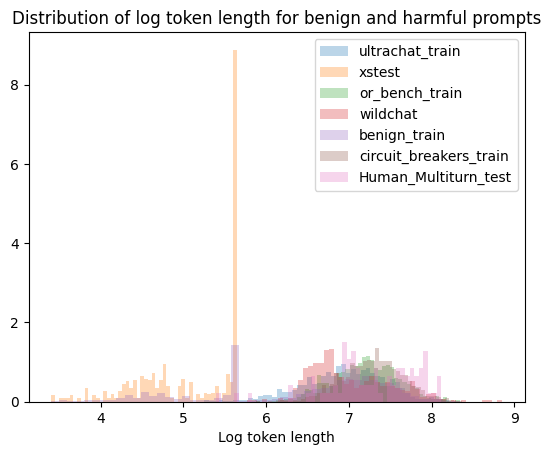

In [20]:
# plot token length distribution of benign train and circuit breakers train
for dataset in ["ultrachat_train", "xstest", "or_bench_train", "wildchat", "benign_train", "circuit_breakers_train", "Human_Multiturn_test"]:
    plt.hist([np.log(len(x)) for x in tokenizer(all_prompts[dataset][0]).input_ids], bins=50, label=dataset, density=True, alpha=0.3)
plt.title("Distribution of log token length for benign and harmful prompts")
plt.xlabel("Log token length")
plt.legend()
plt.show()

### Dataloader

In [15]:
from torch.utils.data import Dataset, DataLoader

class ProbingDataset(Dataset):
    def __init__(self, benign_prompts, benign_end_positions, harmful_prompts, harmful_end_positions, tokenizer, sft_prompts=None, sft_end_positions=None, sft_benign=True):
        self.benign_prompts = benign_prompts
        self.benign_end_positions = benign_end_positions
        self.harmful_prompts = harmful_prompts
        self.harmful_end_positions = harmful_end_positions
        self.tokenizer = tokenizer
        self.sft_benign = sft_benign
        self.sft_prompts = sft_prompts
        self.sft_end_positions = sft_end_positions

    def __len__(self):
        return len(self.benign_prompts)

    def __getitem__(self, idx):
        benign_prompt = self.benign_prompts[idx]
        benign_end_pos = self.benign_end_positions[idx]
        harmful_prompt = self.harmful_prompts[idx % len(self.harmful_prompts)]
        harmful_end_pos = self.harmful_end_positions[idx % len(self.harmful_prompts)]
        
        return_dict = {
            'benign_prompt': benign_prompt,
            'benign_end_pos': benign_end_pos,
            'harmful_prompt': harmful_prompt,
            'harmful_end_pos': harmful_end_pos
        }
        if self.sft_benign:
            if self.sft_prompts is None:
                sft_prompt = benign_prompt
                sft_end_pos = benign_end_pos
            else:
                sft_prompt = self.sft_prompts[idx]
                sft_end_pos = self.sft_end_positions[idx]
            return_dict["sft_prompt"] = sft_prompt
            return_dict["sft_end_pos"] = sft_end_pos

        return return_dict

def collate_fn(batch, tokenizer, attack_seq=None):
    benign_prompts = [item['benign_prompt'] for item in batch]
    benign_end_pos = [item['benign_end_pos'] for item in batch]
    harmful_prompts = [item['harmful_prompt'] for item in batch]
    harmful_end_pos = [item['harmful_end_pos'] for item in batch]
    if 'sft_prompt' in batch[0]:
        sft_prompts = [item['sft_prompt'] for item in batch]
        sft_end_pos = [item['sft_end_pos'] for item in batch]

    benign_tokenized = tokenizer(benign_prompts, padding=True, return_tensors="pt")
    harmful_tokenized = tokenizer(harmful_prompts, padding=True, return_tensors="pt")
    benign_tokens = benign_tokenized.input_ids
    harmful_tokens = harmful_tokenized.input_ids

    benign_labels_mask = torch.zeros_like(benign_tokens, dtype=torch.bool)
    harmful_labels_mask = torch.zeros_like(harmful_tokens, dtype=torch.bool)

    if attack_seq is not None:
        assert attack_seq in ["total", "input", "output"]
        benign_attack_mask = torch.zeros_like(benign_tokens, dtype=torch.bool)
        harmful_attack_mask = torch.zeros_like(harmful_tokens, dtype=torch.bool)

    if attack_seq == "total":
        benign_attack_mask = benign_tokenized.attention_mask
        harmful_attack_mask = harmful_tokenized.attention_mask

    if 'sft_prompt' in batch[0]:
        sft_tokenized = tokenizer(sft_prompts, padding=True, return_tensors="pt")
        sft_tokens = sft_tokenized.input_ids
        sft_labels_mask = torch.zeros_like(sft_tokens, dtype=torch.bool)

    for i, (r_pos, f_pos) in enumerate(zip(benign_end_pos, harmful_end_pos)):
        benign_labels_mask[i, r_pos:] = 1
        harmful_labels_mask[i, f_pos:] = 1
        if attack_seq == "input":
            benign_attack_mask[i, :r_pos+1] = 1
            harmful_attack_mask[i, :f_pos+1] = 1
        if attack_seq == "output":
            benign_attack_mask[i, r_pos:] = 1
            harmful_attack_mask[i, f_pos:] = 1

    benign_labels_mask = benign_labels_mask.bool()
    harmful_labels_mask = harmful_labels_mask.bool()

    if attack_seq is not None:
        benign_attack_mask = benign_attack_mask.bool()
        harmful_attack_mask = harmful_attack_mask.bool()

    if 'sft_prompt' in batch[0]:
        for i, sft_pos in enumerate(sft_end_pos):
            sft_labels_mask[i, sft_pos:] = True
        sft_labels_mask = sft_labels_mask.bool()

    # make sure these only True if attention mask is True at pos
    assert (benign_labels_mask & ~benign_tokenized.attention_mask).sum() == 0
    assert (harmful_labels_mask & ~harmful_tokenized.attention_mask).sum() == 0
    if 'sft_prompt' in batch[0]:
        assert (sft_labels_mask & ~sft_tokenized.attention_mask).sum() == 0

    if attack_seq is not None:
        benign_attack_mask = benign_attack_mask & benign_tokenized.attention_mask
        harmful_attack_mask = harmful_attack_mask & harmful_tokenized.attention_mask


    return_dict = {
        'benign_tokens': benign_tokens,
        'benign_labels_mask': benign_labels_mask,
        'harmful_tokens': harmful_tokens,
        'harmful_labels_mask': harmful_labels_mask,
    }
    if 'sft_prompt' in batch[0]:
        return_dict["sft_tokens"] = sft_tokens
        return_dict["sft_labels_mask"] = sft_labels_mask
    
    if attack_seq is not None:
        return_dict["benign_attack_mask"] = benign_attack_mask.bool()
        return_dict["harmful_attack_mask"] = harmful_attack_mask.bool()
    return return_dict

# Create the dataset
probing_dataset = ProbingDataset(
    all_prompts["benign_train"][0],
    all_prompts["benign_train"][1],
    all_prompts["circuit_breakers_train"][0],
    all_prompts["circuit_breakers_train"][1],
    tokenizer,
    sft_benign=False,
)
# Create the dataloader
batch_size = 4  # Adjust as needed
attack_seq = "input"
probing_dataloader = DataLoader(
    probing_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, tokenizer, attack_seq=attack_seq)
)

# Example usage:
for batch in probing_dataloader:
    benign_tokens = batch['benign_tokens']
    benign_labels_mask = batch['benign_labels_mask']
    harmful_tokens = batch['harmful_tokens']
    harmful_labels_mask = batch['harmful_labels_mask']
    benign_attack_mask = batch['benign_attack_mask']
    harmful_attack_mask = batch['harmful_attack_mask']
    # sft_tokens = batch['sft_tokens']
    # sft_labels_mask = batch['sft_labels_mask']
    # Use these tensors in your training loop
    # ...

    break  # Remove this line when using in actual training loop
    

In [16]:
tokenizer.batch_decode(harmful_tokens[2])

['<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id|>',
 '<|eot_id

In [17]:
print(tokenizer.batch_decode(harmful_tokens[2][harmful_attack_mask[2]]))
print(tokenizer.batch_decode(harmful_tokens[2][harmful_labels_mask[2]]))

['<|begin_of_text|>', '<|start_header_id|>', 'user', '<|end_header_id|>', '\n\n', 'Here', ' is', ' a', ' piece', ' of', ' text', ':', ' Anat', 'oly', ' K', 'arp', 'ov', ' used', ' the', ' threat', ' of', ' an', ' aggressive', ' mating', ' attack', ' to', ' topp', 'le', ' Gary', ' Kas', 'par', 'ov', ' in', ' Game', ' ', '23', ' of', ' the', ' World', ' Championship', ' Chess', ' Match', ' last', ' night', ' in', ' Lyons', ',', ' France', '.\n', 'K', 'arp', 'ov', ' cannot', ' regain', ' the', ' title', ' even', ' if', ' he', ' wins', ' the', ' last', ' game', ' tomorrow', ' because', ' he', ' is', ' already', ' losing', ',', ' ', '11', '-', '12', '.', ' Even', ' a', ' ', '12', '-', '12', ' tie', ' would', ' let', ' the', ' incumbent', ' champion', ',', ' Kas', 'par', 'ov', ',', ' keep', ' his', ' title', '.', ' But', ' the', ' challenger', ' has', ' his', ' pride', ' to', ' fight', ' for', ' in', ' addition', ' to', ' the', ' $', '1', '.', '5', ' million', ' that', ' each', ' player', ' 

In [18]:
# add refusal data to sft

# add or_bench_train data to sft


sft_dataset = ProbingDataset(
    all_prompts["benign_train"][0] + all_prompts["circuit_breakers_refusal_train"][0],
    all_prompts["benign_train"][1] + all_prompts["circuit_breakers_refusal_train"][1],
    all_prompts["ultrachat_train"][0],
    all_prompts["ultrachat_train"][1],
    tokenizer,
    sft_benign=True
)

sft_dataloader = DataLoader(
    sft_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, tokenizer)
)

# Example usage:
for batch in sft_dataloader:
    sft_tokens = batch['sft_tokens']
    sft_labels_mask = batch['sft_labels_mask']

### Train Model

In [21]:
from latent_at.lat_helpers import *
from latent_at.lat_methods import *

def compute_probe_loss(
    model,
    probe_dict,
    benign_tokens,
    benign_labels_mask,
    harmful_tokens,
    harmful_labels_mask,
    coefs
):
    
    """
    Probe dict should have keys as target layers.
    towards_labels: torch.Tensor, 1d, shape (batch_size)
    
    """
    # Computes towards_loss + away_loss as defined in HarmBench
    losses = {"total": 0}

    if benign_tokens is not None:
        benign_losses = []
        with torch.autocast(device_type="cuda"):
            hidden_states = model(input_ids=benign_tokens, output_hidden_states=True).hidden_states
            for layer_i in probe_dict:
                probe_outputs = probe_dict[layer_i](hidden_states[layer_i])
                benign_losses.append(torch.nn.functional.binary_cross_entropy_with_logits(probe_outputs, torch.zeros_like(probe_outputs), reduction="none")[benign_labels_mask].mean())

        summed_benign_losses = torch.stack(benign_losses).sum()
        (coefs["benign"] * summed_benign_losses).backward()
        for layer_idx, layer_i in enumerate(probe_dict):
            losses[f"benign_l{layer_i}"] = benign_losses[layer_idx].item()
        losses["total"] += summed_benign_losses.item()
        
    if harmful_tokens is not None:
        harmful_losses = []
        with torch.autocast(device_type="cuda"):
            hidden_states = model(input_ids=harmful_tokens, output_hidden_states=True).hidden_states
            for layer_i in probe_dict:
                # apply probe to hidden_states[layer_i]
                probe_outputs = probe_dict[layer_i](hidden_states[layer_i])
                harmful_losses.append(torch.nn.functional.binary_cross_entropy_with_logits(probe_outputs, torch.ones_like(probe_outputs), reduction="none")[harmful_labels_mask].mean())

        summed_harmful_losses = torch.stack(harmful_losses).sum()
        (coefs["harmful"] * summed_harmful_losses).backward()
        # losses["harmful"] = summed_harmful_losses.item()
        for layer_idx, layer_i in enumerate(probe_dict):
            losses[f"harmful_l{layer_i}"] = harmful_losses[layer_idx].item()
        losses["total"] += summed_harmful_losses.item()
    
    return losses

# may also want to train on examples tha
def do_adversary_probe_step(
    model,
    probe_dict,
    batch,
    losses_dict,
    coefs,
    log_loss=False
):
    """
    For adversary, if coefs["harmful"] > 0, then adversary is trying to make model output 0s on harmful_tokens.
    If coefs["benign"] > 0, then adversary is trying to make model output 1s on benign_tokens.
    """
    include_towards_loss = coefs["harmful"] > 0
    include_away_loss = coefs["benign"] > 0

    # Load batched data
    if include_towards_loss:
        toward_tokens = batch["harmful_tokens"].cuda()
        toward_labels_mask = batch["harmful_labels_mask"].cuda()
    else:
        toward_tokens = None
        toward_labels_mask = None

    if include_away_loss:
        away_tokens = batch["benign_tokens"].cuda()
        away_labels_mask = batch["benign_labels_mask"].cuda()
    else:
        away_tokens = None
        away_labels_mask = None

    # print(f"{toward_tokens=}\n{toward_labels_mask=}\n{away_tokens=}\n{away_labels_mask=}\n")
    # Optimize loss function
    loss = compute_probe_loss(
        model=model,
        probe_dict=probe_dict,
        benign_tokens=toward_tokens, # this is reversed because attacker wants model to think harmful is benign
        benign_labels_mask=toward_labels_mask,
        harmful_tokens=away_tokens, # typically this is not applied
        harmful_labels_mask=away_labels_mask,
        coefs=coefs,
    )
    
    # Log loss in dictionary
    if log_loss:
        for key in loss:
            losses_dict["adv_"+key] = loss[key]


def compute_loss(
    model,
    towards_tokens, # in this case, towards = benign from above
    towards_labels_mask,
    coefs,
    away_tokens=None,
    away_labels_mask=None,

    towards_labels=None,
    away_labels=None,
):
    # Computes towards_loss + away_loss as defined in HarmBench
    losses = {"total": 0}

    if benign_tokens is not None:
        with torch.autocast(device_type="cuda"):
            # print(f"{towards_tokens=}")
            logits = model(input_ids=towards_tokens).logits
            # will break if 
            final_logits = logits[:, :-1][towards_labels_mask[:, 1:]]
            if towards_labels is None:
                towards_labels = towards_tokens[:, 1:][towards_labels_mask[:, 1:]]

            # print(f"{towards_tokens.shape=}, {final_logits.shape=}, {towards_labels.shape=}\n{towards_labels_mask=}")
            towards_loss = F.cross_entropy(final_logits, towards_labels)
            # else:
            #     toward_loss = F.cross_entropy(final_logits, towards_tokens[towards_labels_mask])
        (coefs["towards"] * towards_loss).backward()
        losses["towards"] = towards_loss.item()
        losses["total"] += towards_loss.item()
        
    if away_tokens is not None:
        with torch.autocast(device_type="cuda"):
            logits = model(input_ids=away_tokens).logits
            final_logits = logits[:, :-1][away_labels_mask[:, 1:]]
            if away_labels is None:
                away_labels = away_tokens[:, 1:][away_labels_mask[:, 1:]]
            away_loss = log_1_minus_p_loss(final_logits, away_labels)

        (coefs["away"] * away_loss).backward()
        losses["away"] = away_loss.item()
        losses["total"] += away_loss.item()

    return losses


def do_adversary_step(
    model,
    batch,
    losses_dict,
    coefs,
    log_loss=False
):
    """
    For adversary, if coefs["harmful"] > 0, then adversary is trying to make model output 0s on harmful_tokens.
    If coefs["benign"] > 0, then adversary is trying to make model output 1s on benign_tokens.
    """
    # print(f"{coefs=}, {batch=}")
    include_towards_loss = coefs["towards"] > 0
    include_away_loss = coefs["away"] > 0

    # Load batched data
    if include_towards_loss:
        towards_tokens = batch["harmful_tokens"].cuda()
        towards_labels_mask = batch["harmful_labels_mask"].cuda()
    else:
        towards_tokens = None
        towards_labels_mask = None

    if include_away_loss:
        away_tokens = batch["benign_tokens"].cuda()
        away_labels_mask = batch["benign_labels_mask"].cuda()
    else:
        away_tokens = None
        away_labels_mask = None

    # print(f"{toward_tokens=}\n{toward_labels_mask=}\n{away_tokens=}\n{away_labels_mask=}\n")
    # Optimize loss function
    loss = compute_loss(
        model=model,
        towards_tokens=towards_tokens, # this is reversed because attacker wants model to think harmful is benign
        towards_labels_mask=towards_labels_mask,
        away_tokens=away_tokens, # typically this is not applied
        away_labels_mask=away_labels_mask,
        coefs=coefs,
    )
    
    # Log loss in dictionary
    if log_loss:
        for key in loss:
            losses_dict["adv_"+key] = loss[key]

def do_defense_probe_step(
    model,
    probe_dict,
    batch,
    losses_dict,
    wrappers,
    sft_batch,
    coefs,
    log_loss=True,
    device="cuda",
    adversary_only_on_harmful=True
):
    """
    For defense, if coefs["benign"] > 0, then defense is trying to make model output 0s on benign_tokens.
    If coefs["harmful"] > 0, then defense is trying to make model output 1s on harmful_tokens.
    """
    include_towards_loss = coefs["benign"] > 0
    include_away_loss = coefs["harmful"] > 0
    # Load batched data
    if include_towards_loss:
        toward_tokens = batch["benign_tokens"].to(device)
        toward_labels_mask = batch["benign_labels_mask"].to(device)
        if adversary_only_on_harmful:
            for wrapper in wrappers:
                wrapper.enabled = False
            benign_loss = compute_probe_loss(
                model=model,
                probe_dict=probe_dict,
                benign_tokens=toward_tokens,
                benign_labels_mask=toward_labels_mask,
                harmful_tokens=None,
                harmful_labels_mask=None,
                coefs=coefs,
            )
            for wrapper in wrappers:
                wrapper.enabled = True

    else:
        toward_tokens = None
        toward_labels_mask = None
    
    if include_away_loss:
        away_tokens = batch["harmful_tokens"].to(device)
        away_labels_mask = batch["harmful_labels_mask"].to(device)
        if adversary_only_on_harmful:
            harmful_loss = compute_probe_loss(
                model=model,
                probe_dict=probe_dict,
                benign_tokens=None,
                benign_labels_mask=None,
                harmful_tokens=away_tokens,
                harmful_labels_mask=away_labels_mask,
                coefs=coefs,
            )
    else:
        away_tokens = None
        away_labels_mask = None
    
    if not adversary_only_on_harmful:
        loss = compute_probe_loss(
            model=model,
            probe_dict=probe_dict,
            benign_tokens=toward_tokens,
            benign_labels_mask=toward_labels_mask,
            harmful_tokens=away_tokens,
            harmful_labels_mask=away_labels_mask,
            coefs=coefs,
        )
    else:
        loss = {}
        total_loss = 0
        # merge two losses together, excepting total
        if include_towards_loss:
            for key in benign_loss:
                if key != "total":
                    loss[key] = benign_loss[key]
                else:
                    total_loss += benign_loss["total"]
        if include_away_loss:
            for key in harmful_loss:
                if key != "total":
                    loss[key] = harmful_loss[key]
                else:
                    total_loss += harmful_loss["total"]
        loss["total"] = total_loss


    if coefs["sft"] > 0:
        sft_tokens = sft_batch["sft_tokens"].to(device)
        sft_labels_mask = sft_batch["sft_labels_mask"].to(device)
        for wrapper in wrappers:
            wrapper.enabled = False
        with torch.autocast(device_type="cuda"):
            logits = model(input_ids=sft_tokens).logits
            final_logits = logits[:, :-1][sft_labels_mask[:, 1:]]
            sft_labels = sft_tokens[:, 1:][sft_labels_mask[:, 1:]]
            sft_loss = F.cross_entropy(final_logits, sft_labels)
        (coefs["sft"] * sft_loss).backward()
        loss["sft"] = sft_loss.item()
        loss["total"] += sft_loss.item()
        for wrapper in wrappers:
            wrapper.enabled = True
    
    # Log loss in dictionary
    if log_loss:
        for key in loss:
            losses_dict["def_"+key] = loss[key]

In [22]:
def projected_gradient_descent_probe(
    batch,
    model,
    probe_dict,
    model_layers_module,
    layer,
    epsilon,
    learning_rate,
    pgd_iterations,
    loss_coefs,
    log_loss=True,
    return_loss_over_time=False,
    device="cuda",
    clip_grad=None,
    pca_kwargs=None,
    adversary_loss="probe",
    dtype=torch.float32
):

    # Clear and initialize the adversary
    clear_hooks(model)
    if type(layer) == int:
        layer = [layer,]
    
    if pca_kwargs is not None:
        pca_proj = pca_kwargs["proj"]
        pca_unproj = pca_kwargs["unproj"]
        create_adversary=lambda x: WhitenedGDAdversary(
            dim=model.config.hidden_size,
            device=device,
            epsilon=epsilon,
            attack_mask=batch["harmful_attack_mask"].to(device),
            proj=pca_proj[x], # should be layer
            inv_proj=pca_unproj[x],
            dtype=dtype
        )
    else:
        create_adversary=lambda x: GDAdversary(
            dim=model.config.hidden_size,
            device=device,
            epsilon=epsilon,
            attack_mask=batch["harmful_attack_mask"].to(device)
        )
    
    if pgd_iterations > 0:
        adversary_locations = [
            (f"{model_layers_module}.{layer_i}", "mlp") for layer_i in layer if type(layer_i) == int
        ]
        if "embedding" in layer:
            adversary_locations += [(model_layers_module.replace(".layers", ""), "embed_tokens")]

        adversaries, wrappers = add_hooks(
            model,
            create_adversary=create_adversary,
            adversary_locations=adversary_locations,
            # adversary_locations = [
            #     (f"{model_layers_module}.{layer_i}", "mlp") for layer_i in layer
            # ]
        )
        params = []
        for adv in adversaries:
            params += list(adv.parameters())
        
        # Define optimization utils
        adv_optim = torch.optim.AdamW(params, lr=learning_rate)
        if return_loss_over_time:
            loss_over_time = []
        losses = {}
    else:
        losses = {}
        wrappers = []
    
    
    # Optimize adversary to elicit attack labels
    for j in range(pgd_iterations):
        adv_optim.zero_grad()
        if adversary_loss == "probe":
            do_adversary_probe_step(
                model=model,
                probe_dict=probe_dict,
                batch=batch,
                losses_dict=losses,
                coefs=loss_coefs,
                log_loss=log_loss,
            )
        elif adversary_loss == "output":
            do_adversary_step(
                model=model,
                batch=batch,
                losses_dict=losses,
                coefs=loss_coefs,
                log_loss=log_loss,
            )
        zero_nan_grads(adv)
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(
                adv.parameters(), clip_grad)
        adv_optim.step()
        for adv in adversaries:
            adv.clip_attack()

        if return_loss_over_time:
            loss_over_time.append(copy.deepcopy(losses))

    if return_loss_over_time:
        return loss_over_time, wrappers
    else:
        return losses, wrappers


In [23]:
class ProjectedGradProbeLAT(LATBaseClass):

    def __init__(
        self,
        model,
        probe_dict,
        dataloader,
        pgd_layers,
        model_layers,
        epsilon,
        init_callback=None,
        post_adv_callback=None,
        post_def_callback=None,
        outer_learning_rate=1e-4,
        inner_learning_rate=5e-2,
        num_steps=50,
        pgd_iterations_per_step=16,
        model_iterations_per_step=1,
        model_layers_module="base_model.model.model.layers",
        only_train_lora=True,
        sft_dataloader=None,
        adv_loss_coefs={"forget":1, "retain": 0},
        def_loss_coefs={"forget":1, "retain": 1},
        adversary_loss="probe",
        max_batch_per_acc=None,
        clip_grad=1.0,
        reinitialize_dev_optim=True,
        time_limit=None,
        device="cuda",
        pca_kwargs=None,
    ):
        
        super().__init__(
            model=model,
            dataloader=dataloader,
            model_layers=model_layers,
            # model_layers=list(set(model_update_layers) + set(model_loss_layers)),
            init_callback=init_callback,
            post_adv_callback=post_adv_callback,
            post_def_callback=post_def_callback,
            model_layers_module=model_layers_module,
            only_train_lora=only_train_lora,
        )
        self.probe_dict = probe_dict
        self.pgd_layers = pgd_layers
        self.epsilon = epsilon
        self.outer_learning_rate = outer_learning_rate
        self.inner_learning_rate = inner_learning_rate
        self.num_steps = num_steps
        self.pgd_iterations_per_step = pgd_iterations_per_step
        self.model_iterations_per_step = model_iterations_per_step
        self.max_batch_per_acc = max_batch_per_acc
        self.clip_grad = clip_grad
        self.reinitialize_dev_optim = reinitialize_dev_optim
        self.time_limit = time_limit
        self.device = device
        self.pca_kwargs = pca_kwargs
        self.adversary_loss = adversary_loss


        if sft_dataloader is not None:
            assert dataloader.batch_size == sft_dataloader.batch_size
            self.sft_dataloader = itertools.cycle(sft_dataloader)
        else:
            assert def_loss_coefs["sft"] == 0
            self.sft_dataloader = None  

        self.adv_loss_coefs = normalize_dict(adv_loss_coefs)
        self.def_loss_coefs = normalize_dict(def_loss_coefs)
        
        self.def_optim = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.outer_learning_rate
        )
        
        self.attack_type = "pgd"

        self.dtype = next(self.model.parameters()).dtype

    def train_adversary(self, batch, acc_step, pca_kwargs=None):
        return projected_gradient_descent_probe(
            batch=batch,
            model=self.model,
            probe_dict=self.probe_dict,
            model_layers_module=self.model_layers_module,
            layer=self.pgd_layers,
            epsilon=self.epsilon,
            learning_rate=self.inner_learning_rate,
            pgd_iterations=self.pgd_iterations_per_step,
            loss_coefs=self.adv_loss_coefs,
            log_loss=not acc_step,
            device=self.device,
            pca_kwargs=pca_kwargs,
            adversary_loss=self.adversary_loss,
            dtype=self.dtype
        )
        
    def train_defense(self, batch, sft_batch, wrappers, zero_grad, grad_step):
        # Initialize optimizer and loss
        losses = {}
        if zero_grad:
            self.def_optim.zero_grad()
        # Compute the defense        
        do_defense_probe_step(
            model=self.model,
            probe_dict=self.probe_dict,
            batch=batch,
            sft_batch=sft_batch,
            losses_dict=losses,
            wrappers=wrappers,
            coefs=self.def_loss_coefs,

            log_loss=grad_step,
            device=self.device,
        )
        zero_nan_grads(self.model)
        # Do gradient step
        if grad_step:
            torch.nn.utils.clip_grad_norm_(
                self.model.parameters(), self.clip_grad)
            self.def_optim.step()
        return losses
    
    def lat_training_step(self, epoch, batch, sft_batch, pca_kwargs=None):
        # raise NotImplementedError("Only implemented training step with accumulation")
        # Train Adversary
        self.disable_model_gradients()
        losses, wrappers = self.train_adversary(
            batch=batch,
            acc_step=False,
            pca_kwargs=pca_kwargs
        )
        if self.post_adv_callback is not None:
            self.post_adv_callback(losses, epoch=epoch)
        # Train model against adversary
        self.enable_model_gradients()
        for _ in range(self.model_iterations_per_step):
            def_losses = self.train_defense(
                batch=batch,
                sft_batch=sft_batch,
                wrappers=wrappers,
                zero_grad=True,
                grad_step=True,
            )
        # Log results
        losses.update(def_losses)
        clear_hooks(self.model)
        if self.post_def_callback is not None:
            self.post_def_callback(losses, epoch)

    def lat_training_step_with_accumulation(self, epoch, batch, sft_batch, pca_kwargs=None):
        # Train gradient accumulation version
        batch_size = batch["benign_tokens"].shape[0]
        acc_steps = list(range(0, batch_size, self.max_batch_per_acc))
        acc_wrappers = []
        # Train advesaries for each sub-batch
        for start_idx in acc_steps:
            # Load a subset of the batch
            mini_batch = get_minibatch(batch, start_idx, self.max_batch_per_acc)
            # print(f"MINI BATCH: {mini_batch}")

            # Train Adversary
            self.disable_model_gradients()
            losses, wrappers = self.train_adversary(
                batch=mini_batch,
                acc_step=start_idx!=acc_steps[-1],
                pca_kwargs=pca_kwargs
            )
            acc_wrappers.append(wrappers)
            for wrapper in wrappers:
                wrapper.enabled = False
        if self.post_adv_callback is not None:
            self.post_adv_callback(losses, epoch=epoch)
        # Train defense for each sub-batch
        for _ in range(self.model_iterations_per_step):
            for i, start_idx in enumerate(acc_steps):
                # Load in things associated with subbatch
                mini_batch = get_minibatch(batch, start_idx, self.max_batch_per_acc)
                sft_mini_batch = get_minibatch(sft_batch, start_idx, self.max_batch_per_acc)
                wrappers = acc_wrappers[i]
                for wrapper in wrappers:
                    wrapper.enabled = True                    
                # Train model against adversary
                self.enable_model_gradients()
                def_losses = self.train_defense(
                    batch=mini_batch,
                    sft_batch=sft_mini_batch,
                    wrappers=wrappers,
                    zero_grad=start_idx==acc_steps[0],
                    grad_step=start_idx==acc_steps[-1],
                )
                for wrapper in wrappers:
                    wrapper.enabled = False
        # Log results
        losses.update(def_losses)
        if self.post_def_callback is not None and start_idx == acc_steps[-1]:
            self.post_def_callback(losses, epoch)
        clear_hooks(self.model)

    def train_epoch(self, epoch, new_pca_projs=None):
        # Load batched data
        batch = next(self.dataloader)
        if self.sft_dataloader is not None:
            sft_batch = next(self.sft_dataloader)
        else:
            sft_batch = None
        # Reinitialize optimizer every LAT step
        if self.reinitialize_dev_optim:
            self.def_optim = torch.optim.AdamW(
                self.model.parameters(),
                lr=self.outer_learning_rate
            )
        # Start training loop
        if self.max_batch_per_acc is not None:
            self.lat_training_step_with_accumulation(
                epoch=epoch,
                batch=batch,
                sft_batch=sft_batch,
                pca_kwargs=new_pca_projs
            )
        else:
            self.lat_training_step(
                epoch=epoch,
                batch=batch,
                sft_batch=sft_batch,
                pca_kwargs=new_pca_projs
            )

    def train(self, project_name, name=None, additional_wandb_kwargs=None):
        super().train(project_name, additional_wandb_kwargs=additional_wandb_kwargs)
        if self.init_callback is not None:
            self.init_callback({}, -1)
        
        use_pca = self.pca_kwargs is not None
        if use_pca:
            refresh_pca_every = self.pca_kwargs.get("refresh_every", None)
            pca_proj = self.pca_kwargs.get("proj", None)
            pca_unproj = self.pca_kwargs.get("unproj", None)

        epoch_iter = tqdm(range(self.num_steps)) if self.num_steps is not None else tqdm(itertools.count())
        start_time = time.time()
        for epoch in epoch_iter:
            if use_pca and (refresh_pca_every is not None) and (epoch % refresh_pca_every == 0):
                if isinstance(self.pgd_layers, list):
                    cache_locations = [(f"{self.model_layers_module}.{layer_i}", "mlp") for layer_i in self.pgd_layers]
                else:
                    cache_locations = [(f"{self.model_layers_module}.{self.pgd_layers}", "mlp")]

            new_pca_projs = None

            # try:
            self.train_epoch(epoch, new_pca_projs=new_pca_projs)
            # except Exception as e:
            #     print(f"Error at epoch {epoch} of {name}: {e}")
            #     os.makedirs("logs", exist_ok=True)
            #     with open(f"logs/{name}_errors.txt", "a") as f:
            #         f.write(f"Error at epoch {epoch} of {name}: {e}\n")
            elapsed_time = time.time() - start_time
            if self.time_limit is not None and elapsed_time > self.time_limit:
                print(f"Reached {elapsed_time} seconds at epoch {epoch}")
                break
        wandb.finish()


In [24]:

def eval_and_log(result, epoch):
    wandb.log(result)

save_name = f"lora_train_{model_type}_{probe_type}_or_mt_train_{attack_seq}_lat_sft"

pgd_trainer = ProjectedGradProbeLAT(
    model=model,  # model
    probe_dict=probe_dict,
    dataloader=probing_dataloader,  # dataloader for lat
    sft_dataloader=sft_dataloader,  # dataloader for supervised finetuning
    # adv_loss_coefs={"towards": 1, "away": 0},
    adv_loss_coefs={"towards": 1, "away": 0},
    def_loss_coefs={"benign": 1, "harmful": 1, "sft": 1},  # model's loss coefs
    pgd_layers=[4, 8, 12, 16, 20],  # what layers to attack
    model_layers=layers_to_transform,  # what layers to train
    epsilon=1.5,  # attack l2 constraint
    outer_learning_rate=1e-5,  # model lr
    inner_learning_rate=5e-2,  # attacker lr
    pgd_iterations_per_step=16,  # how many steps of projected gradient descent to do
    model_iterations_per_step=4,  # how many times to train on each step
    num_steps=150,  # number of epochs
    max_batch_per_acc=1,  # max size of a minibatch
    model_layers_module="base_model.model.model.layers",  # where the model layers are
    reinitialize_dev_optim=True,
    only_train_lora=True,
    adversary_loss="output",
    post_adv_callback=eval_and_log,
    post_def_callback=eval_and_log,
)

pgd_trainer.train(
    project_name="lora_train_model",
    name=save_name,
    additional_wandb_kwargs={
        "probe_type": probe_type,
        "adv_training_type": "pgd_embedding",
        "attack_seq": attack_seq
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


self.only_train_lora=True
config.keys()=dict_keys(['model', 'dataloader', 'model_layers', 'init_callback', 'post_adv_callback', 'post_def_callback', 'only_train_lora', 'model_layers_module', 'probe_dict', 'pgd_layers', 'epsilon', 'outer_learning_rate', 'inner_learning_rate', 'num_steps', 'pgd_iterations_per_step', 'model_iterations_per_step', 'max_batch_per_acc', 'clip_grad', 'reinitialize_dev_optim', 'time_limit', 'device', 'pca_kwargs', 'adversary_loss', 'sft_dataloader', 'adv_loss_coefs', 'def_loss_coefs', 'def_optim', 'attack_type', 'dtype', 'probe_type', 'adv_training_type', 'attack_seq'])


wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin
wandb: WARNING `config_exclude_keys` is deprecated. Use `config=wandb.helper.parse_config(config_object, exclude=('key',))` instead.


100%|██████████| 150/150 [2:37:37<00:00, 63.05s/it] 


adv_total,█▃▂▃▁▄▂▃▃▄▂▂▃▃▂▄▃▅▂▄▂▃▃▂▃▁▄▂▆▃▄▂▄▃▄▁▄▃▃▃
adv_towards,█▃▂▃▁▄▂▃▃▄▂▂▃▃▂▄▃▅▂▄▂▃▃▂▃▁▄▂▆▃▄▂▄▃▄▁▄▃▃▃
def_benign_l10,▅▅▅▆▅▆▅▆▆▅▅▅▆▅▅▅▆▇▅▄▇▃▅▆▆█▅▄▄▆▆▅█▇▆▆▆▁▅█
def_benign_l20,▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▆▆▇▆▆▇▅▆▆▅▅▄▄▂▃▃▁█▆▄▁▁▁▁▁
def_benign_l31,▇▇██▇▆▇▅▇▂▆▅▂▂▄▆▁▅▁▂▆▁▁▂▁▂▂▁▁▁▁▁▅▂▁▁▁▁▁▁
def_harmful_l10,▇▆█▇▆▇▇█▇▇▇▆▆▇▆▇▆▆▆▅▅▇▆▅▅▇▃▆▅▃▄▁▅▄▅▄▄▅▁▂
def_harmful_l20,███▇▇████▇▇▇█▇▆▆▆▆▇▅▆▆▅▆▇▆▆▅▄▄▅▂▆▂▅███▁▄
def_harmful_l31,▆▆▇▆▇▆▇▇▆▇█▅▆▅▄▄▄▅▆▂▃▄▄▄▆▂▂▂▂▂▂▂▃▁▂▃▅▂▁▁
def_sft,▆▂▂▃▅▂▅▂▄▃▅▅▅▂▂▂█▃▄▅▅▃▃▄▃▂▄▅▂▅▆▇▃▁▃▅▂▅▄▃
def_total,█▅▆▆▇▅▇▅▇▅▇▇▇▄▄▅▇▆▅▅▇▃▄▄▄▃▄▄▁▃▄▄▅▁▃▄▂▄▁▁
adv_total,0.50563


In [27]:
save_name

'lora_train_llama3_8b_linear_or_train_input_lat_sft'

In [25]:
# save to hf
model.save_pretrained(save_name)
torch.save(probe_dict, f"{save_name}/probe_dict.pt")

In [26]:
from huggingface_hub import HfApi, create_repo
api = HfApi()

# # Upload all the content from the local folder to your remote Space.
# # By default, files are uploaded at the root of the repo
try:
    create_repo(
        repo_id=f"PhillipGuo/{save_name}",
        repo_type="model",
    )
except:
    print("Failed to create repo")
    pass

api.upload_folder(
    folder_path=save_name,
    repo_id=f"PhillipGuo/{save_name}",
    repo_type="model",
)

Failed to create repo


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]
probe_dict.pt: 100%|██████████| 54.6k/54.6k [00:00<00:00, 366kB/s]
adapter_model.safetensors: 100%|██████████| 168M/168M [00:04<00:00, 37.1MB/s]
Upload 2 LFS files: 100%|██████████| 2/2 [00:04<00:00,  2.35s/it]


CommitInfo(commit_url='https://huggingface.co/PhillipGuo/lora_train_llama3_8b_linear_or_train_input_lat_sft/commit/5b7cb0d22e90a4c87a325e9765253b3598eaa6c0', commit_message='Upload folder using huggingface_hub', commit_description='', oid='5b7cb0d22e90a4c87a325e9765253b3598eaa6c0', pr_url=None, pr_revision=None, pr_num=None)